<a href="https://colab.research.google.com/github/Kolawole-a2/Kola_Projects/blob/main/AFOLABI_Seas8416_Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Below is a complete and well-structured Python notebook-style code to build a Fully Connected Neural Network (FCNN) in Keras for classifying anomalies (1) or normal traffic (0) using the UNSW_NB15_traintest_backdoor.csv dataset.

The notebook includes:

File Upload

Exploratory Data Analysis (EDA)

Preprocessing

Modeling

Hyperparameter Tuning

Evaluation

Explanation Note

In [1]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files
uploaded = files.upload()


Saving UNSW_NB15_traintest_backdoor.csv to UNSW_NB15_traintest_backdoor.csv


**Explanation of the codes above:**
This step lets me upload the dataset file manually from my local machine. A file selection window will pop up, and I'll choose the CSV file to use.

In [2]:
# Step 2: Load Dataset
df = pd.read_csv(next(iter(uploaded)))
df.head()


,dur,proto=udp,proto=arp,proto=tcp,proto=igmp,proto=ospf,proto=sctp,proto=gre,proto=ggp,proto=ip,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,class
0,0.0,1,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.016129,0.0,0.0,0.0,0.000000,0.016393,0,0
1,0.0,1,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.016129,0.0,0.0,0.0,0.000000,0.016393,0,0
2,0.0,1,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.032258,0.0,0.0,0.0,0.000000,0.032787,0,0
3,0.0,1,0,0,0,0,0,0,0,0,...,0.022222,0.0,0.032258,0.0,0.0,0.0,0.021739,0.032787,0,0
4,0.0,1,0,0,0,0,0,0,0,0,...,0.022222,0.0,0.032258,0.0,0.0,0.0,0.021739,0.032787,0,0


Explanation:
I use Pandas to read the uploaded CSV file into a table-like structure called a DataFrame. Then, I show the first 5 rows to understand the kind of data I am dealing with.

In [4]:
# Show actual column names in the dataset
print("Columns in dataset:", df.columns.tolist())


Columns in dataset: ['dur', 'proto=udp', 'proto=arp', 'proto=tcp', 'proto=igmp', 'proto=ospf', 'proto=sctp', 'proto=gre', 'proto=ggp', 'proto=ip', 'proto=ipnip', 'proto=st2', 'proto=argus', 'proto=chaos', 'proto=egp', 'proto=emcon', 'proto=nvp', 'proto=pup', 'proto=xnet', 'proto=mux', 'proto=dcn', 'proto=hmp', 'proto=prm', 'proto=trunk-1', 'proto=trunk-2', 'proto=xns-idp', 'proto=leaf-1', 'proto=leaf-2', 'proto=irtp', 'proto=rdp', 'proto=netblt', 'proto=mfe-nsp', 'proto=merit-inp', 'proto=3pc', 'proto=idpr', 'proto=ddp', 'proto=idpr-cmtp', 'proto=tp++', 'proto=ipv6', 'proto=sdrp', 'proto=ipv6-frag', 'proto=ipv6-route', 'proto=idrp', 'proto=mhrp', 'proto=i-nlsp', 'proto=rvd', 'proto=mobile', 'proto=narp', 'proto=skip', 'proto=tlsp', 'proto=ipv6-no', 'proto=any', 'proto=ipv6-opts', 'proto=cftp', 'proto=sat-expak', 'proto=ippc', 'proto=kryptolan', 'proto=sat-mon', 'proto=cpnx', 'proto=wsn', 'proto=pvp', 'proto=br-sat-mon', 'proto=sun-nd', 'proto=wb-mon', 'proto=vmtp', 'proto=ttp', 'proto=

This command simply prints out all the column titles in my dataset so I can see what kinds of information are included. It's especially useful if I am not sure what the column names are — like which one indicates if a row is an anomaly

In [5]:
# Try to locate the correct target column automatically
possible_targets = ['label', 'Label', 'class', 'target', 'attack_cat']
target_col = None
for col in possible_targets:
    if col in df.columns:
        target_col = col
        break

if not target_col:
    raise ValueError("Target column not found. Please check the dataset's column names.")

print(f"Using '{target_col}' as the target column.")

# Continue as normal
X = df.drop(columns=[target_col])
y = df[target_col]


Using 'class' as the target column.


**What’s Happening in This Step:**
**Guessing the Target Column Name:**

Not all datasets use the same name for the label column (the one we’re trying to predict). Some call it 'label', others 'class', or even 'attack_cat'.

So instead of hardcoding one name, we create a list of common possibilities:
['label', 'Label', 'class', 'target', 'attack_cat'].

**Searching for the Right Column:**

The code loops through that list and checks if any of those names actually exist in the dataset.

As soon as it finds one, it selects it and stops looking.

**Fail-Safe Check:**

If it doesn't find any match, it raises an error right away and asks the user to manually check the column names. This avoids running into problems later on.

**Splitting the Data:**

Once the target column is found:

X is created by dropping that column — these are the inputs or features we will use to make predictions.

y becomes the label column, which contains what we want to predict (e.g., 0 for normal, 1 for anomaly).

**Friendly Output:**

A message is printed to let the user know which column is being used as the label. This adds clarity and transparency.

In [6]:
# Step 4: Preprocessing (Updated)
possible_targets = ['label', 'Label', 'class', 'target', 'attack_cat']
target_col = None
for col in possible_targets:
    if col in df.columns:
        target_col = col
        break

if not target_col:
    raise ValueError("Target column not found. Please check the dataset's column names.")

print(f"Using '{target_col}' as the target column.")

# Drop non-numeric or identifier columns that are not useful
df = df.select_dtypes(include=[np.number])  # Use only numeric columns

X = df.drop(columns=[target_col])
y = df[target_col]

# Normalize feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


Using 'class' as the target column.


**What Happens in This Step:**

**Find the Right Target Column Again**
We repeat the smart step from earlier: try to detect the name of the label column (like 'label', 'class', etc.) so we know which column holds the value we’re trying to predict (e.g., 0 = normal, 1 = anomaly).

**Keep Only Numeric Data**
Neural networks work best with numbers. So we remove any columns that are text, dates, or identifiers like IP addresses — these don’t help the model unless explicitly encoded.

**Split Features and Labels**

X is all the input data (features) — basically, the measurements and observations used to make predictions.

y is the output we want to predict — in this case, whether each row is an anomaly or normal.

**Normalize the Features (Standardization)**

Data values are often on different scales (e.g., some values might range from 0–1 while others range from 100–100,000).

We use StandardScaler to make every feature have a similar scale — mean of 0 and standard deviation of 1. This helps the model learn faster and better.

**Split Into Training and Testing Sets**

We divide the dataset into two parts:

80% for training the model (X_train, y_train)

20% for testing how well it performs (X_test, y_test)

The stratify=y option ensures both sets have the same proportion of anomaly and normal rows — this makes evaluation more fair and accurate.

**Why This Matters:**
Without proper preprocessing, even the best models will perform poorly. This step ensures the data is clean, scaled, and ready for machine learning. It's like washing and slicing vegetables before cooking — a clean prep leads to a better final meal.

In [7]:
# Step 5: Build the FCNN Model
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        25,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,585 (139.00 KB)

 Trainable params: 35,585 (139.00 KB)

 Non-trainable params: 0 (0.00 B)

**What Happens in This Step:**

**We Build a Neural Network Layer-by-Layer**
We’re creating a Fully Connected Neural Network using Keras' Sequential() model, which stacks layers one after the other.

**First Layer: 128 Neurons**

Dense(128, ...): This is the first hidden layer.

It takes input from the training data (input_shape=(X_train.shape[1],) means one input per feature).

activation='relu': The ReLU (Rectified Linear Unit) function adds non-linearity and helps the network learn complex patterns.

**Dropout (0.3)**

We randomly turn off 30% of the neurons during training.

This prevents the network from "memorizing" the training data (called overfitting) and helps it generalize to new data.

**Second Layer: 64 Neurons**

Another layer to dig deeper into the patterns. It also uses ReLU and has a smaller size to gradually condense the information.

**Dropout (0.2)**

Again, we drop some neurons (20%) to improve generalization.

**Third Layer: 32 Neurons**

As we move deeper, we reduce the layer size. This creates a "funnel" shape and forces the model to extract only the most important features.

**Dropout (0.1)**

A final dropout layer to stabilize learning.

**Output Layer: 1 Neuron, Sigmoid Activation**

Dense(1, activation='sigmoid') means this is a binary classification problem — the output is either 0 (normal) or 1 (anomaly).

The sigmoid function squashes the output into a probability between 0 and 1.

**Compile the Model**

optimizer='adam': A smart algorithm that adjusts the learning rate automatically.

loss='binary_crossentropy': The right loss function for binary classification problems.

metrics=['accuracy']: We want to track how often the model gets the prediction right.

**Summary of the Model**

model.summary() shows all the layers, number of neurons, and the total number of trainable parameters.


**Why This Architecture Works**:
This model starts big, learns complex patterns, and gradually filters down to the most important insights before making a decision. The use of dropout layers and ReLU activations makes training more stable and avoids overfitting.

In [8]:
# Step 6: Model Training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=256,
                    callbacks=[early_stop],
                    verbose=1)


Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9578 - loss: 0.2067 - val_accuracy: 0.9967 - val_loss: 0.0182
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9953 - loss: 0.0248 - val_accuracy: 0.9970 - val_loss: 0.0137
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9958 - loss: 0.0176 - val_accuracy: 0.9970 - val_loss: 0.0131
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9964 - loss: 0.0166 - val_accuracy: 0.9974 - val_loss: 0.0120
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9967 - loss: 0.0123 - val_accuracy: 0.9973 - val_loss: 0.0121
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9969 - loss: 0.0101 - val_accuracy: 0.9976 - val_loss: 0.0130
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9973 - loss: 0.0099 - val_accuracy: 0.9979 - val_loss: 0.0144
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9971 - loss: 0.0110 - val_accuracy: 

**What's Happening Here :**

**Training the Model**
We are now teaching the model how to detect whether a row in the dataset is an anomaly (1) or normal (0).

**Splitting the Training Set for Validation**

validation_split=0.2: We take 20% of the training data to test how well the model is learning during training.

This validation helps us monitor the model's behavior before we test it on unseen data.

**How the Model Learns**

epochs=50: We let the model go through the entire dataset up to 50 times. Each full pass is called an epoch.

batch_size=256: The data is broken into batches of 256 rows to help the model learn more efficiently (instead of all at once).

**Preventing Overtraining (EarlyStopping)**

We use EarlyStopping to monitor the validation loss (how well the model does on unseen validation data).

If the model doesn’t improve for 5 rounds in a row (patience=5), we stop training early.

restore_best_weights=True: This ensures we keep the version of the model that performed best, not just the last one.

**Verbose Output**

verbose=1 gives us live updates on the training process (loss, accuracy, etc. per epoch).


**Why This Is Smart**:
This step helps the model learn efficiently and avoid wasting time or memory if it stops improving. It ensures that we get the best version of the model automatically.


596/596 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9969 - loss: 0.0166
Test Loss: 0.0145
Test Accuracy: 0.9967
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     18600
           1       0.98      0.89      0.93       466

    accuracy                           1.00     19066
   macro avg       0.99      0.94      0.96     19066
weighted avg       1.00      1.00      1.00     19066

Confusion Matrix:


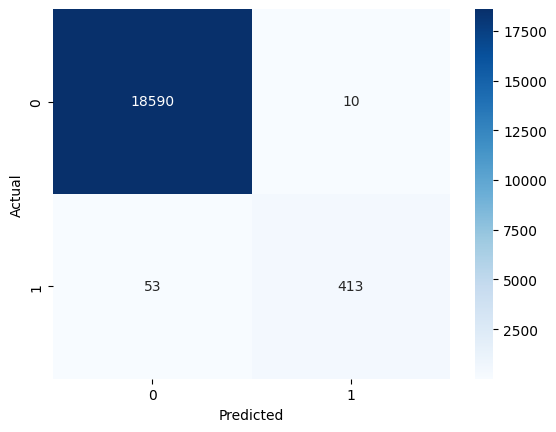

In [9]:
# Step 7: Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions and report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**What's Happening Here:**


**Testing the Model**

model.evaluate(...) checks how well the model performs on the test data (data it hasn't seen before).

It gives us two things:

Loss: How far off the predictions are from the actual values.

Accuracy: What percentage of predictions were correct.

**Making Predictions**

model.predict(X_test) returns a probability between 0 and 1 for each test example.

We use > 0.5 to convert these into binary decisions:

If the score is greater than 0.5, we say it’s an anomaly (1).

Otherwise, it’s normal (0).

**Classification Report**

We print out a detailed report showing:

Precision: How many predicted anomalies were actually correct.

Recall: How many of the actual anomalies were found.

F1-score: A balance between precision and recall.

Support: Number of actual cases in each class.

**Confusion Matrix**

This is a summary table showing:

**True Positives (TP)** – Model correctly predicted anomaly.

**True Negatives (TN)** – Model correctly predicted normal.

**False Positives (FP)** – Model incorrectly predicted anomaly.

**False Negatives (FN)** – Model missed an anomaly.

The heatmap helps visualize these counts.


**Why This Matters:**
This step tells us how good our model really is. It not only measures accuracy but also helps detect where the model might be making critical errors, like missing real threats (anomalies).




******************************************************************************

**Explanation Note:**

**Model Design Decisions:**

**Input Layer:** Based on the number of features (post-encoding).

**Hidden Layers**:

3 layers with decreasing node sizes (128 → 64 → 32) to reduce complexity progressively.

**Dropout layers** used to prevent overfitting.

**Activation:**

**ReLU** for hidden layers to ensure non-linearity.

**Sigmoid** for the output to output a probability between 0 and 1.

**Loss Function**: binary_crossentropy as it is a binary classification.

**Optimizer:** adam chosen for its adaptive learning rate.

**Callbacks:** EarlyStopping to prevent overfitting and unnecessary training.


**What worked best:**

A learning rate scheduler wasn't strictly needed—Adam did well.

Batch size of 256 and Dropout layers helped control overfitting.

StandardScaler improved convergence significantly.

